In [4]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import numpy as np
from scipy.stats import zscore
from scipy.special import logit
from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests

from sklearn.decomposition import PCA

In [61]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
# data_dir = '../../data/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_neurogenesis_rd = pd.read_csv(data_dir + 'tiklova_neurogenesis/rd_pc2.tab', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.scores.txt', sep='\t', index_col=0)
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)
tiklova_kw = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
# tiklova_kw = pd.read_csv(data_dir + 'tiklova_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
tiklova_mrna = pd.read_csv('/mnt/lareaulab/cfbuenabadn/data_sc_regulation/tiklova/mrna_counts.tab', sep='\t', index_col=0)[tiklova_neurogenesis_rd.index]

geary_C = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_autocor_one_matrix/tiklova_GearyC_k100.tab',
                     sep='\t', index_col=0)

geary_C.columns = ['C_score', 'pvals']

In [7]:
tiklova_kw = tiklova_kw.loc[tiklova_psix.index]
tiklova_kw['qvals'] = multipletests(tiklova_kw.pvals, method='fdr_bh')[1]

# geary_C = geary_C.loc[tiklova_psix.index]
geary_C['qvals'] = multipletests(geary_C.pvals, method='fdr_bh')[1]

In [70]:
psix_exons = tiklova_psix.sort_values('L_score')[-200:].index
geary_exons = geary_C.loc[tiklova_psix.index & geary_C.index].sort_values('C_score')[-200:].index
kw_exons = tiklova_kw.sort_values('KW_score')[-200:].index

In [71]:
pca_psix = PCA().fit_transform(tiklova_PSI.loc[psix_exons].fillna(tiklova_PSI.loc[psix_exons].mean()).T)
pca_kw = PCA().fit_transform(tiklova_PSI.loc[kw_exons].fillna(tiklova_PSI.loc[kw_exons].mean()).T)
pca_geary = PCA().fit_transform(tiklova_PSI.loc[geary_exons].fillna(tiklova_PSI.loc[geary_exons].mean()).T)

In [79]:
psix_exons & geary_exons

Index(['Ap2a1_2', 'Sorbs1_11', 'Fez2_1', 'Clasp1_16', 'Lrrfip1_8', 'Atxn2_5',
       'Add1_4', 'Pdlim7_8', 'Abi2_2', 'P4htm_1',
       ...
       'Cadm1_3', 'Morf4l2_7', 'Ncam1_6', 'Dst_5', 'Cadm1_10', 'Gabrg2_1',
       'Mapt_3', 'Dbn1_1', 'Ndrg4_1', 'Mapt_1'],
      dtype='object', length=114)

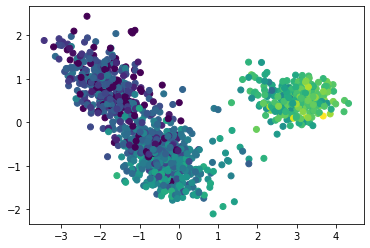

In [76]:
plt.scatter(pca_psix.T[0], pca_psix.T[1], c=np.log10(tiklova_mrna.loc['Snap25']+1))

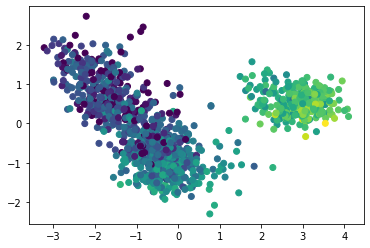

In [75]:
plt.scatter(pca_kw.T[0], pca_kw.T[1], c=np.log10(tiklova_mrna.loc['Snap25']+1))

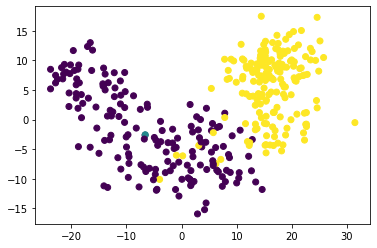

In [12]:
# Exon good for Psix, not for KW
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Dst_5', tiklova_neurogenesis_rd.index])

In [80]:
def get_ranks(scores_df, score_name, bins=50):
    score_series = scores_df.sort_values(score_name).sort_values(score_name)
    ranks_dict = dict()
    total_exons = len(scores_df.index)
    exons_per_rank = int(total_exons/bins)
    for i in range(bins):
        bin_str = i+1
        bin_lims = -exons_per_rank*i
        if i == bins - 1:
            rank_exons = scores_df.sort_values(score_name).index[:bin_lims]
        elif i == 0:
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:]
        else:
            
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:bin_lims]
        ranks_dict.update({bin_str:rank_exons})
    return ranks_dict
    

def make_comparison(df1, df2, score1, score2, bins=50):
    
    rank_df = pd.DataFrame()
    rank_df_exons = pd.DataFrame()
    
    ranks1 = get_ranks(df1, score1, bins)
    ranks2 = get_ranks(df2, score2, bins)
    
    for i in range(1, bins+1):
        shared_list = []
        shared_exons_list = []
        r1_i = ranks1[i]
        for j in range(1, bins+1):
            r2_j = ranks2[j]
            
            shared = len(r1_i & r2_j)
            
            shared_list.append(len(r1_i & r2_j))
            shared_exons_list.append(r1_i & r2_j)
            
        rank_df['bin_' + str(i)] = shared_list
        rank_df_exons['bin_' + str(i)] = shared_exons_list
        
    rank_df.index = ['bin_' + str(i) for i in range(1, bins+1)]
    rank_df_exons.index = ['bin_' + str(i) for i in range(1, bins+1)]
    
    return rank_df, rank_df_exons
        

Text(50.0, 0.5, 'Psix ranks')

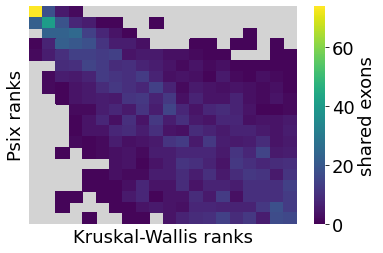

In [81]:
comparison, comparison_exons = make_comparison(tiklova_kw.loc[tiklova_psix.index], tiklova_psix.loc[tiklova_psix.index],
                             'KW_score', 'L_score', bins=20)
mask = comparison == 0
                             
g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
# g = sns.heatmap(comparison, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

# g.tick_params(labelsize=0)
g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

In [99]:
psix_good = pd.Index([])
for bin_good in ['bin_'+str(x) for x in range(1, 11)]:
    for bin_bad in ['bin_'+str(x) for x in range(11, 21)]:

        psix_good = psix_good | comparison_exons.loc[bin_good, bin_bad]
        
kw_good = pd.Index([])
for bin_good in ['bin_'+str(x) for x in range(1, 11)]:
    for bin_bad in ['bin_'+str(x) for x in range(11, 21)]:

        kw_good = kw_good | comparison_exons.loc[bin_bad, bin_good]

In [104]:
psix_good

Index(['Aasdhppt_2', 'Anapc16_4', 'Angel2_3', 'Ankrd16_nmdSE_1',
       'Ankrd16_nmdSE_2', 'Apbb2_8', 'Arfip2_nmdSE_1', 'Arhgap33_4',
       'Arhgap44_3', 'Armcx1_4',
       ...
       'Ubxn7_3', 'Zdbf2_1', 'Zdbf2_3', 'Zdhhc1_2', 'Zdhhc1_3', 'Zfp266_8',
       'Zfp280d_nmdSE_3', 'Zfp558_1', 'Zfp558_3', 'Zfp612_1'],
      dtype='object', length=204)

In [105]:
pca_psix = PCA().fit_transform(tiklova_PSI.loc[psix_good].fillna(tiklova_PSI.loc[psix_good].mean()).T)
pca_kw = PCA().fit_transform(tiklova_PSI.loc[kw_good].fillna(tiklova_PSI.loc[kw_good].mean()).T)

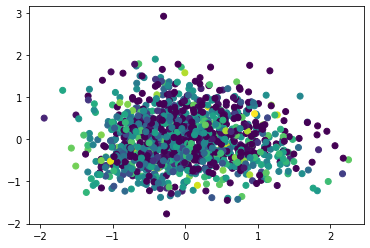

In [125]:
plt.scatter(pca_kw.T[0], pca_kw.T[1], c=np.log10(tiklova_mrna.loc['Snapc3']+1))

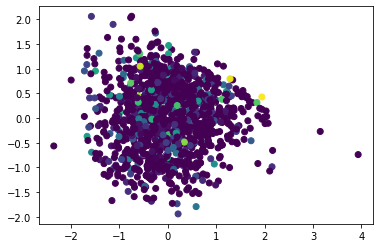

In [127]:
plt.scatter(pca_psix.T[0], pca_psix.T[1], c=np.log10(tiklova_mrna.loc['Ptbp3']+1))

In [ ]:
['Nova1', 'Nova2', 'Ptbp1', 'Ptbp2', 'Ptbp2', 'Ptbp2']

In [ ]:
import hotspot
hs = hotspot.Hotspot(tiklova_mrna, model='danb', latent=pca_results, umi_counts=umi_counts)

In [120]:
[x for x in tiklova_mrna.index if 'Snap' in x]

['Snapin',
 'Snap47',
 'Snapc2',
 'Snapc1',
 'Snap29',
 'Snap25',
 'Snap23',
 'Snapc3',
 'Snapc5',
 'Snap91',
 'Snapc4']